# Introduction to scvi-tools

In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch

/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
  """ Class for doing community detection using the Leiden algorithm.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invalid escape sequence '\s'
  """ Optimise the given partitions simultaneously.


/usr/local/lib/python3.12/site-packages/ml_collections/config_dict/config_dict.py:163: SyntaxWarning: invalid escape sequence '\['
  index_match = re.match("(.*)\[([0-9]+)\]", key)


/usr/local/lib/python3.12/site-packages/pyro/ops/stats.py:514: SyntaxWarning: invalid escape sequence '\g'
  """


/usr/local/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on data loading for more examples.

- Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

```{important}
All scvi-tools models require AnnData objects as input.
```

In [5]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir.name)
adata

INFO     Downloading file at /tmp/tmpozhg38bq/hca_subsampled_20k.h5ad                                              


Downloading...:   0%|          | 0/65714.0 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api.html#module-scanpy.pp).

In [6]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

```{important}
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized). scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts (e.g. SoupX-corrected counts), and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

In [7]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

In [8]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [9]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

```{warning}
If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.
```

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [10]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it.

In [11]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

```{important}
All scvi-tools models run faster when using a GPU. By default, scvi-tools will use a GPU if one is found to be available. Please see the installation page for more information about installing scvi-tools when a GPU is available.
```

In [12]:
model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [13]:
model_dir = os.path.join(save_dir.name, "scvi_model")
model.save(model_dir, overwrite=True)

In [14]:
model = scvi.model.SCVI.load(model_dir, adata=adata)

INFO     File /tmp/tmpozhg38bq/scvi_model/model.pt already downloaded                                              


## Obtaining model outputs

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [15]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(18641, 10)

The `model.get...()` functions default to using the AnnData that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [16]:
adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
latent_subset = model.get_latent_representation(adata_subset)
latent_subset.shape

INFO     Received view of anndata, making copy.                                                                    


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(2446, 10)

In [17]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

,ISG15,TNFRSF18,VWA1,HES5,SPSB1
GTCAAGTCATGCCACG-1-HCAHeart7702879,0.853625,0.075539,1.162070,0.033292,2.058455
GAGTCATTCTCCGTGT-1-HCAHeart8287128,1.221812,0.006103,2.320589,0.015244,19.637251
CCTCTGATCGTGACAT-1-HCAHeart7702881,1.770401,0.033893,1.904653,0.075346,2.018809
CGCCATTCATCATCTT-1-H0035_apex,0.267276,0.101147,0.925400,0.052329,5.811943
TCGTAGAGTAGGACTG-1-H0015_septum,0.582645,0.192482,0.550459,0.227434,5.466261


Let's store the normalized values back in the anndata.

In [18]:
SCVI_NORMALIZED_KEY = "scvi_normalized"

adata.layers[SCVI_NORMALIZED_KEY] = model.get_normalized_expression(library_size=10e4)

## Interoperability with Scanpy

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

### Visualization without batch correction

```{warning}
We use UMAP to *qualitatively* assess our low-dimension embeddings of cells. We do not advise using UMAP or any similar approach quantitatively. We do recommend using the embeddings produced by scVI as a plug-in replacement of what you would get from PCA, as we show below.
```

First, we demonstrate the presence of nuisance variation with respect to nuclei/whole cell, age group, and donor by plotting the UMAP results of the top 30 PCA components for the raw count data.

In [19]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

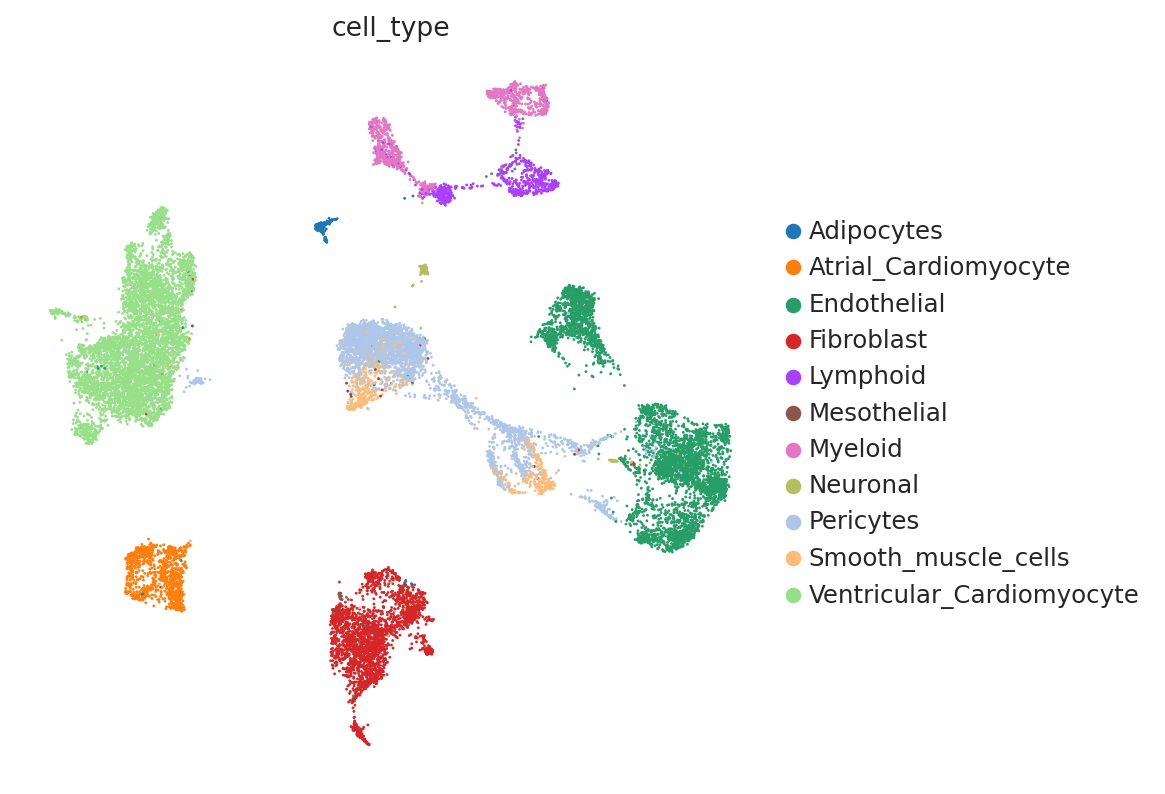

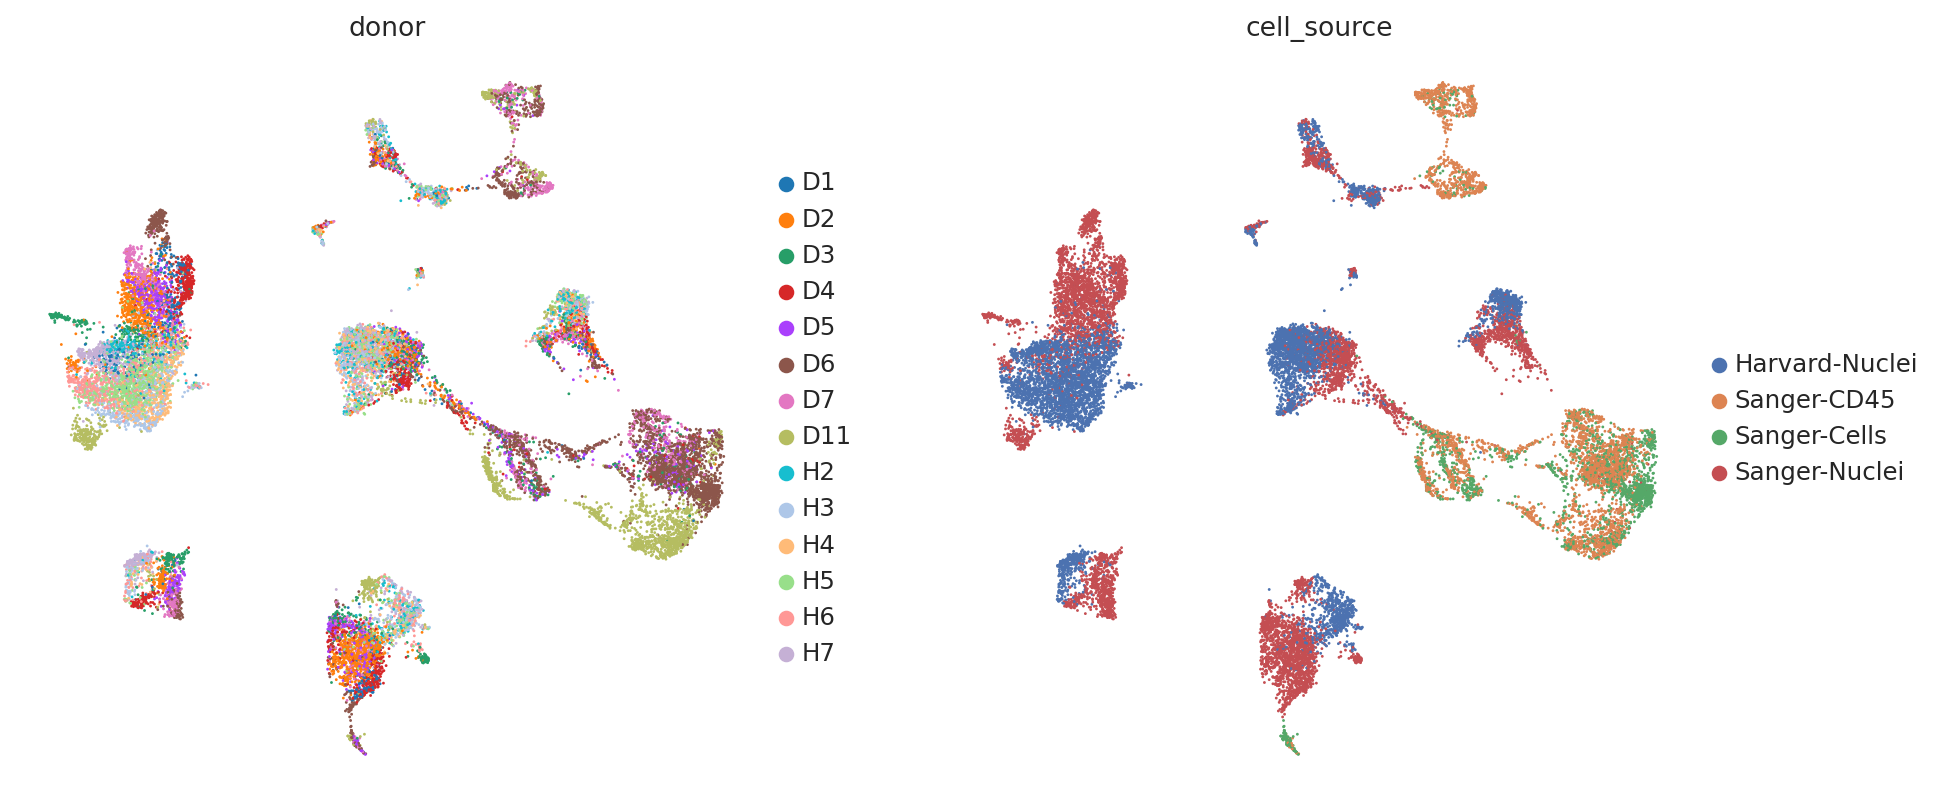

In [20]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

We see that while the cell types are generally well separated, nuisance variation plays a large part in the variation of the data.

### Visualization with batch correction (scVI)

Now, let us try using the scVI latent space to generate the same UMAP plots to see if scVI successfully accounts for batch effects in the data.

In [21]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

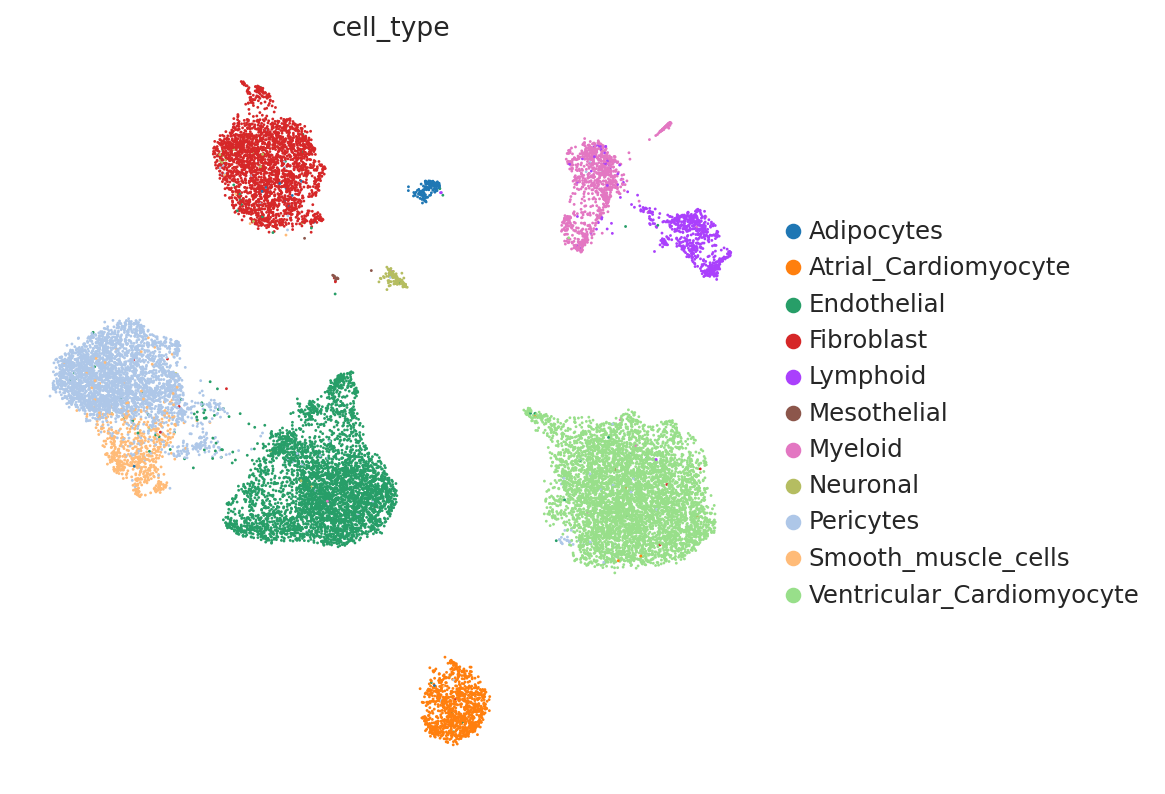

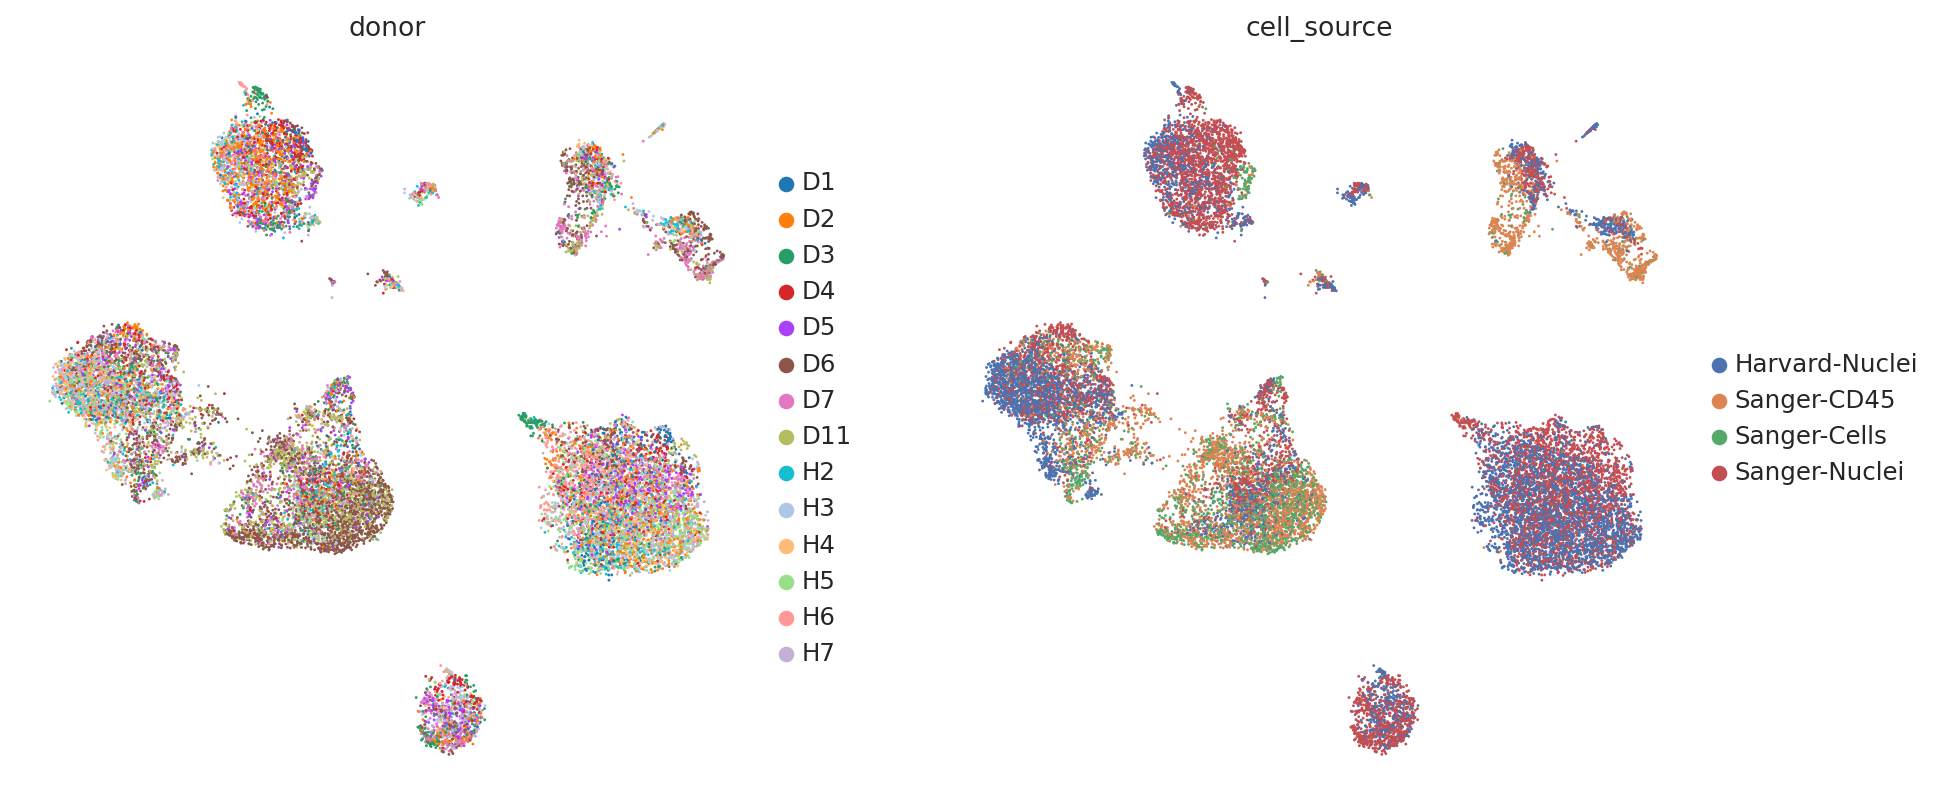

In [22]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

We can see that scVI was able to correct for nuisance variation due to nuclei/whole cell, age group, and donor, while maintaining separation of cell types.

### Clustering on the scVI latent space

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI (e.g., for differential expression).

In [23]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

/tmp/ipykernel_154/3580189653.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)


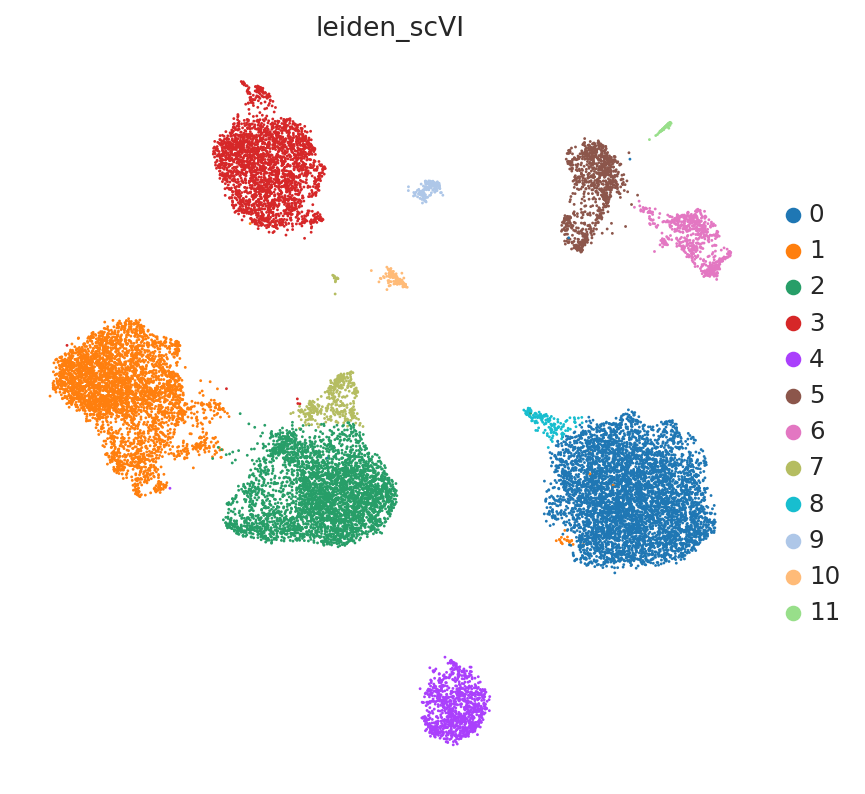

In [24]:
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)

## Differential expression

We can also use many scvi-tools models for differential expression. For further details on the methods underlying these functions as well as additional options, please see the [API docs](https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.html#scvi.model.SCVI.differential_expression).

In [25]:
adata.obs.cell_type.head()

AACTCCCCACGAGAGT-1-HCAHeart7844001                      Myeloid
ATAACGCAGAGCTGGT-1-HCAHeart7829979    Ventricular_Cardiomyocyte
GTCAAGTCATGCCACG-1-HCAHeart7702879                   Fibroblast
GGTGATTCAAATGAGT-1-HCAHeart8102858                  Endothelial
AGAGAATTCTTAGCAG-1-HCAHeart8102863                  Endothelial
Name: cell_type, dtype: category
Categories (11, object): ['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast', ..., 'Neuronal', 'Pericytes', 'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte']

For example, a 1-vs-1 DE test is as simple as:

In [26]:
de_df = model.differential_expression(
    groupby="cell_type", group1="Endothelial", group2="Fibroblast"
)
de_df.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
EGFL7,0.9908,0.0092,4.679308,0.007024,0.000391,0.004206,0.25,4.445938,4.441740,1.500671,...,2.376779,0.036795,0.741543,0.025756,89.507553,1.169474,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
VWF,0.9890,0.0110,4.498798,0.014524,0.000667,0.004206,0.25,4.706915,4.713974,1.672913,...,5.072563,0.054375,0.808226,0.032298,169.693512,2.207696,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
DCN,0.9866,0.0134,-4.299009,0.000982,0.024181,0.004206,0.25,-5.006292,-5.122031,1.758704,...,0.108785,7.574429,0.073010,0.848733,7.380540,261.481750,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
CDH19,0.9852,0.0148,-4.198217,0.000209,0.011520,0.004206,0.25,-7.281450,-7.526304,2.318489,...,0.049890,3.217938,0.014359,0.672527,1.843119,137.330276,True,Endothelial vs Fibroblast,Endothelial,Fibroblast
ABCA8,0.9806,0.0194,-3.922891,0.000407,0.017626,0.004206,0.25,-6.415690,-6.745398,2.283536,...,0.036505,3.181145,0.018496,0.768602,1.501560,183.288528,True,Endothelial vs Fibroblast,Endothelial,Fibroblast


We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

In [27]:
de_df = model.differential_expression(groupby="cell_type", mode="change")
de_df.head()

DE...:   0%|          | 0/11 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
ACACB,0.9402,0.0598,2.755087,0.028567,0.002409,0.01326,0.25,4.424410,4.225316,2.438419,...,24.041380,0.808042,0.889655,0.318339,340.140686,25.794081,False,Adipocytes vs Rest,Adipocytes,Rest
MGST1,0.9342,0.0658,2.653071,0.010587,0.000911,0.01326,0.25,5.212773,5.579885,2.276848,...,7.324136,0.209126,0.889655,0.092561,130.160873,8.808773,False,Adipocytes vs Rest,Adipocytes,Rest
GPAM,0.9228,0.0772,2.481013,0.021902,0.000187,0.01326,0.25,6.964306,7.074643,2.086920,...,17.372416,0.035791,0.896552,0.031520,280.340485,1.565905,False,Adipocytes vs Rest,Adipocytes,Rest
ACSL1,0.9076,0.0924,2.284677,0.008970,0.000695,0.01326,0.25,4.166207,4.067336,1.763820,...,7.199997,0.232265,0.889655,0.146680,113.053543,7.059413,False,Adipocytes vs Rest,Adipocytes,Rest
FASN,0.8692,0.1308,1.893904,0.012233,0.000150,0.01326,0.25,6.310681,6.473874,1.956743,...,7.062068,0.025086,0.841379,0.022167,129.074371,1.084626,False,Adipocytes vs Rest,Adipocytes,Rest


We now extract top markers for each cluster using the DE results.

In [28]:
markers = {}
cats = adata.obs.cell_type.cat.categories
for c in cats:
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [29]:
sc.tl.dendrogram(adata, groupby="cell_type", use_rep="X_scVI")

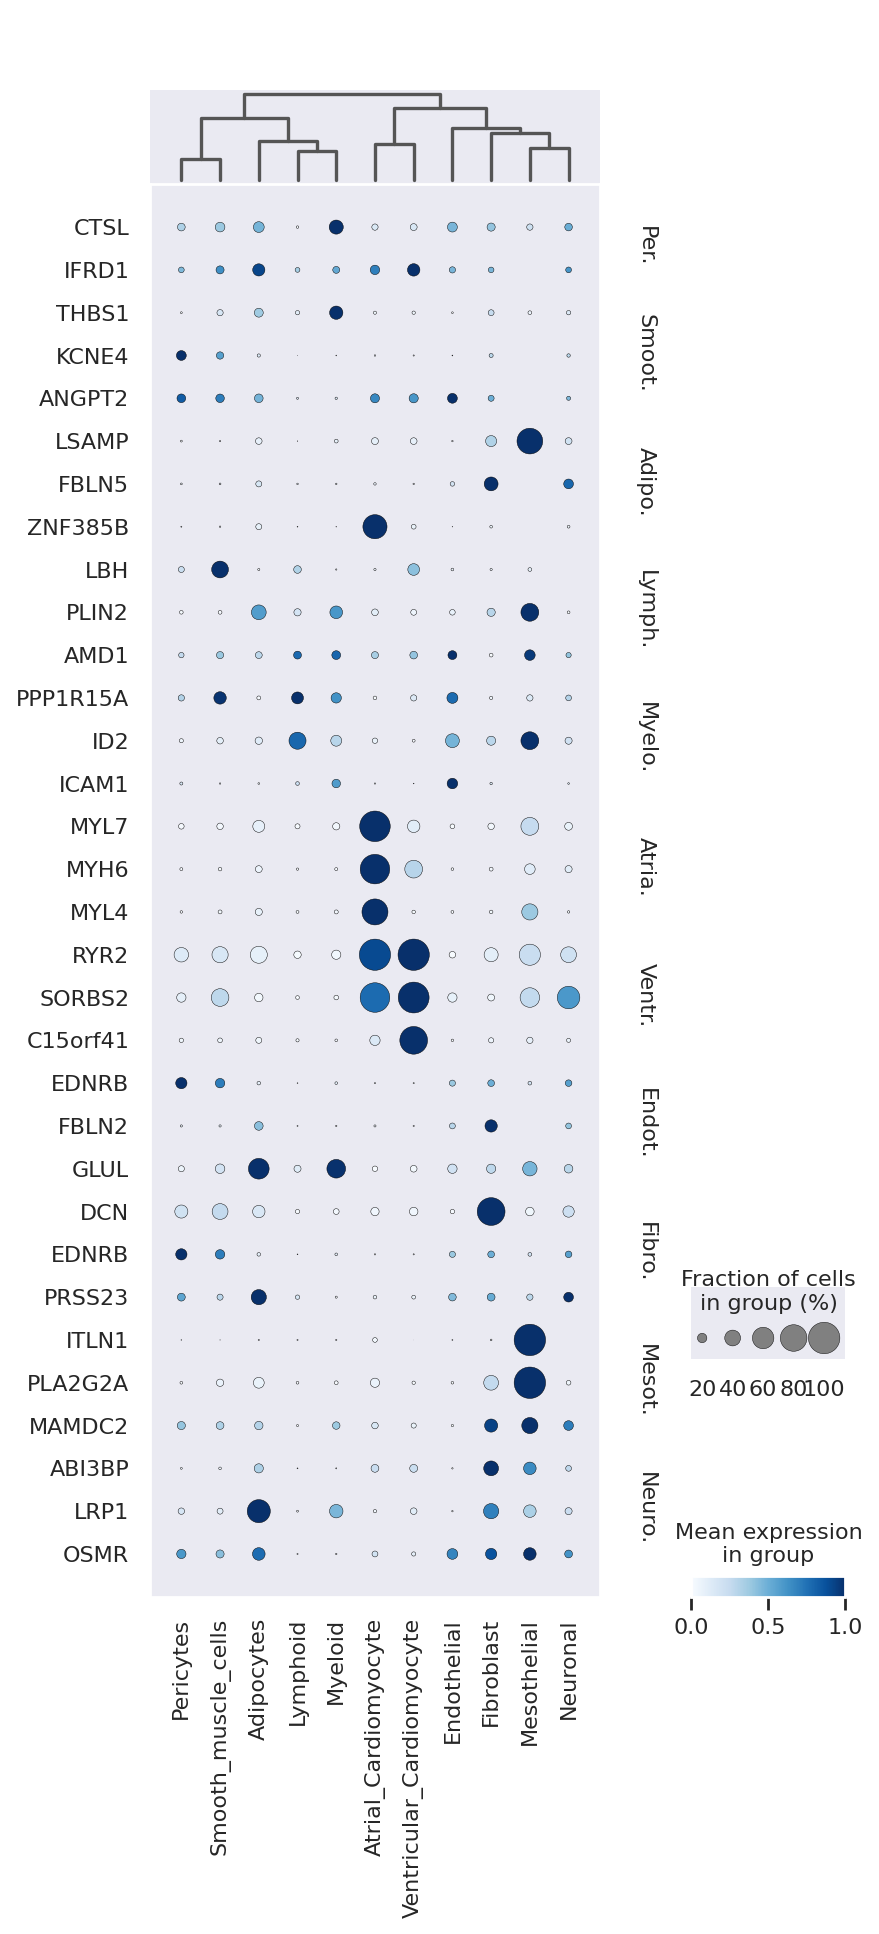

In [30]:
sc.pl.dotplot(
    adata,
    markers,
    groupby="cell_type",
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

We can also visualize the scVI normalized gene expression values with the `layer` option.

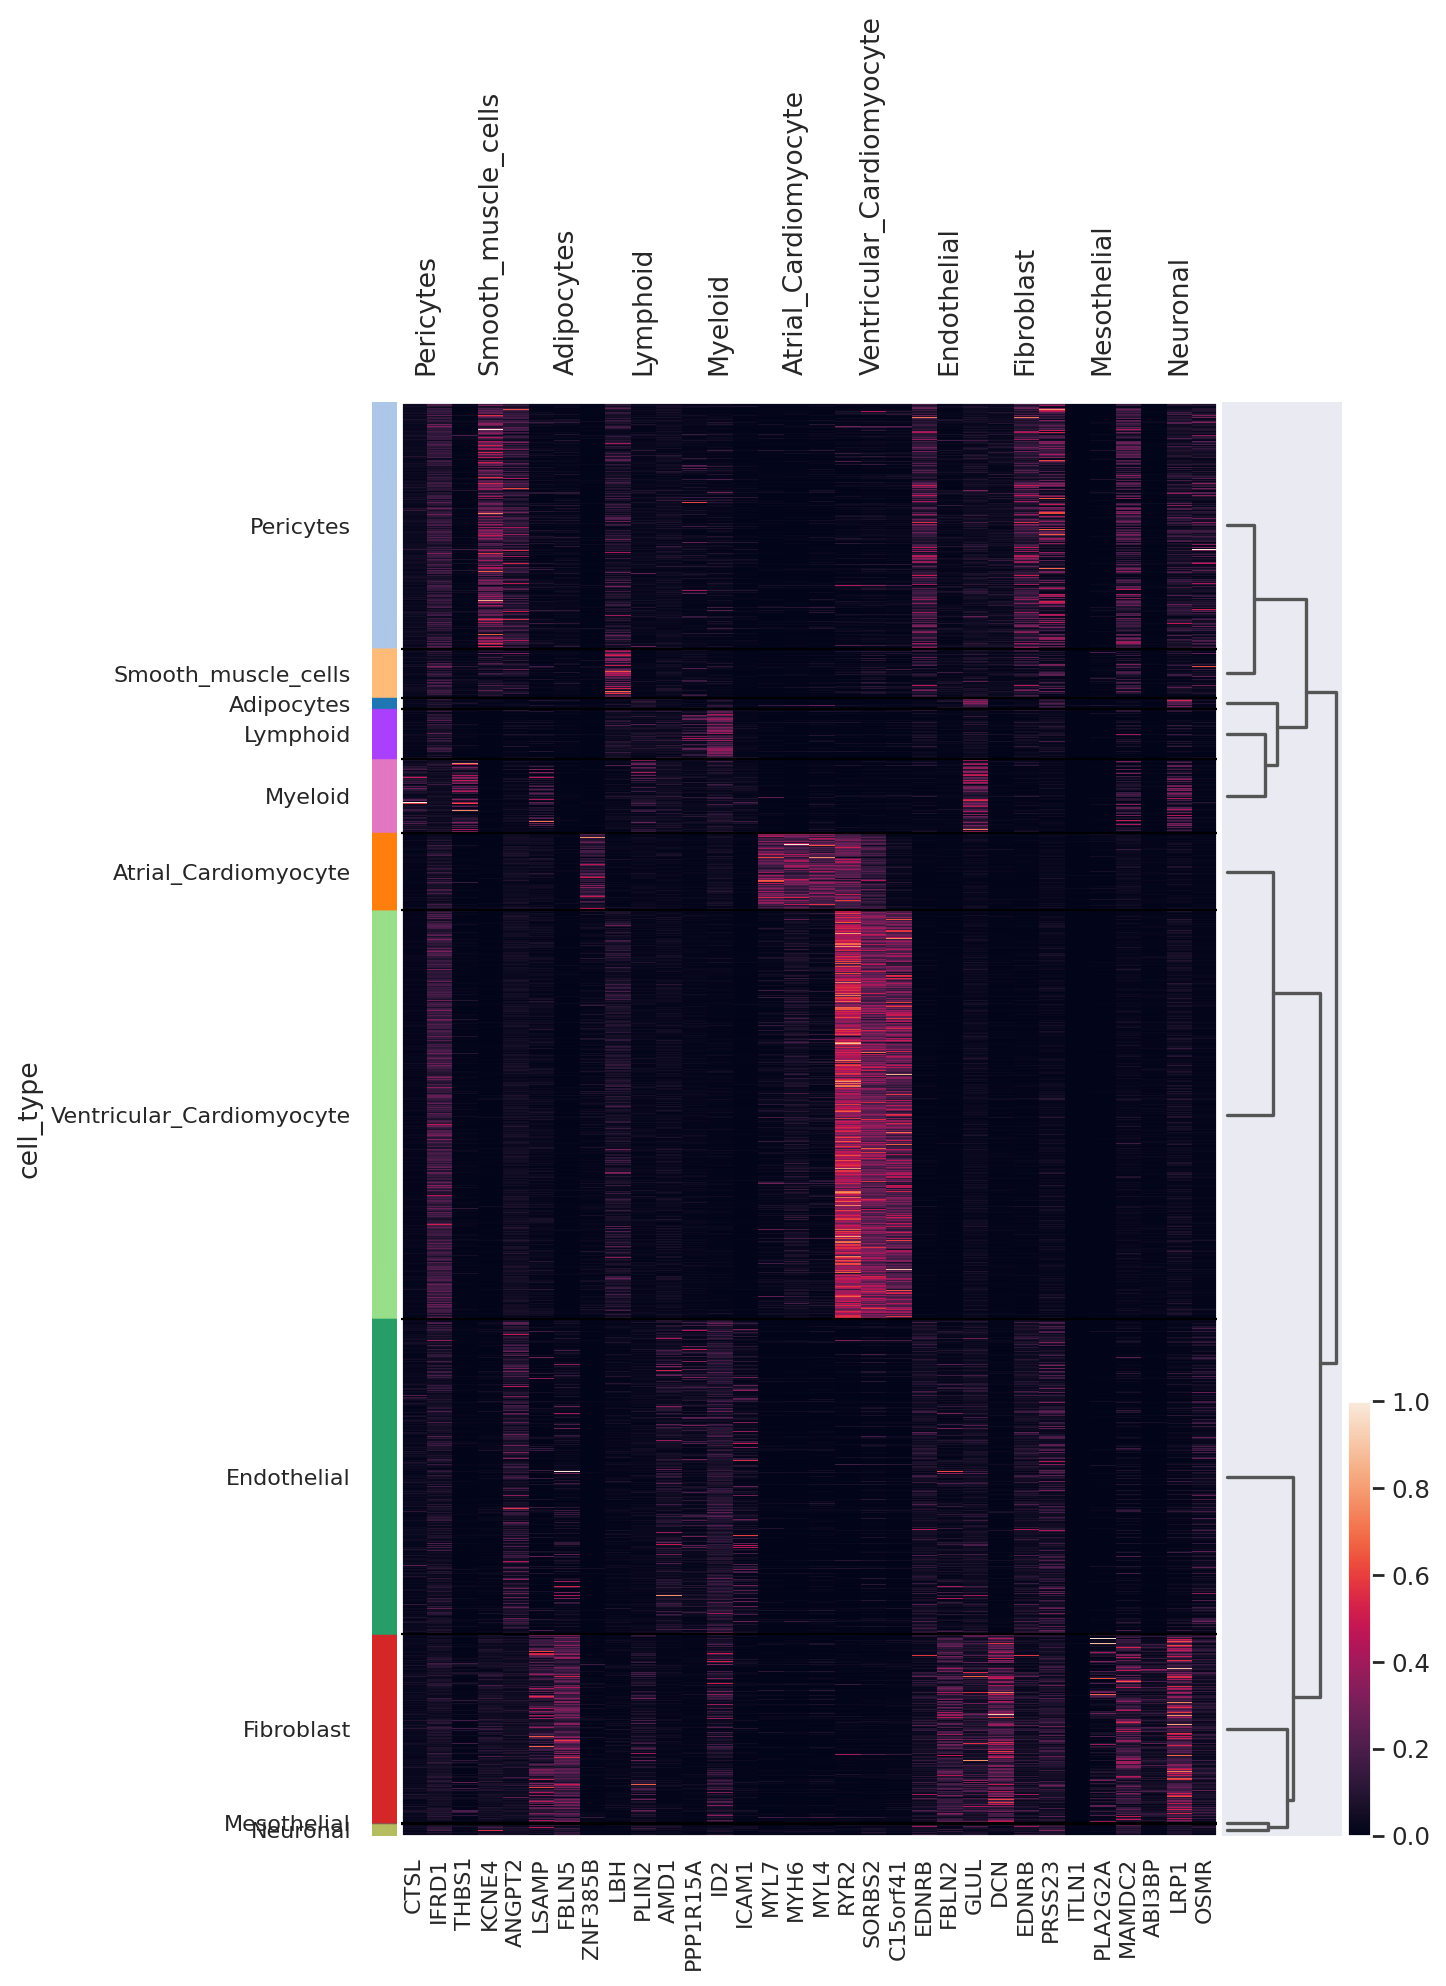

In [31]:
sc.pl.heatmap(
    adata,
    markers,
    groupby="cell_type",
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12),
)

## Logging information

Verbosity varies in the following way:

- `logger.setLevel(logging.WARNING)` will show a progress bar.
- `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
- `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.settings.verbosity` to set the verbosity of the scvi package.
Note that `verbosity` corresponds to the logging levels of the standard python `logging` module. By default, that verbosity level is set to `INFO` (=20).
As a reminder the logging levels are:

<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>